# Transfer Learning

In [1]:
#instantiating the vgg16 convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False,
                 input_shape=(150,150,3))

58889256/58889256 [==============================] - 109s 2us/step


- weights specifies the weight checkpoint from which to initialize the model. 
- include_top refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog), you don’t need to include it.
- input_shape is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to
process inputs of any size

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

The final feature map has shape (4, 4, 512). That’s the feature on top of which you’ll stick a densely connected classifier. 

At this point, there are two ways you could proceed: 
1. Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier similar to those you saw in part 1 of this book. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.

2. Extending the model you have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

## Feature Extraction without data augmentation

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = "cats_and_dogs_small"
train_dir = os.path.join(base_dir,"train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [8]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) #run image through the vgg16 base
        features[i*batch_size:(i+1)*batch_size] = features_batch #sore the extracted features
        labels[i*batch_size:(i+1)*batch_size] = labels_batch #store the corresponding label
        i+=1
        
        #generators yield data indefinitely, you must break after every image has been seen once
        if i*batch_size >= sample_count:
            break
        
        return features, labels

In [9]:
train_features, train_labels = extract_features(train_dir,2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 870ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 903ms/step


The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192)

In [10]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

At this point, you can define your densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that you just recorded.

In [13]:
#defining and training the densely connected classifier
from keras import models, layers, optimizers

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30, batch_size=20,
                   validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 3s 25ms/step - loss: 0.6897 - acc: 0.9955 - val_loss: 0.6861 - val_acc: 0.9910
Epoch 2/30
100/100 [==============================] - 2s 24ms/step - loss: 0.6824 - acc: 0.9960 - val_loss: 0.6788 - val_acc: 0.9920
Epoch 3/30
100/100 [==============================] - 2s 22ms/step - loss: 0.6747 - acc: 0.9970 - val_loss: 0.6702 - val_acc: 0.9910
Epoch 4/30
100/100 [==============================] - 2s 22ms/step - loss: 0.6639 - acc: 0.9985 - val_loss: 0.6601 - val_acc: 0.9940
Epoch 5/30
100/100 [==============================] - 2s 22ms/step - loss: 0.6549 - acc: 0.9995 - val_loss: 0.6529 - val_acc: 0.9930
Epoch 6/30
100/100 [==============================] - 2s 21ms/step - loss: 0.6473 - acc: 0.9975 - val_loss: 0.6420 - val_acc: 0.9950
Epoch 7/30
100/100 [==============================] - 2s 24ms/step - loss: 0.6364 - acc: 0.9985 - val_loss: 0.6341 - val_acc: 0.9930
Epoch 8/30
100/100 [==============================] - 2s 23ms/step - 

Training is very fast, because you only have to deal with two Dense layers—an epoch takes less than one second even on CPU.

Let’s look at the loss and accuracy curves during training

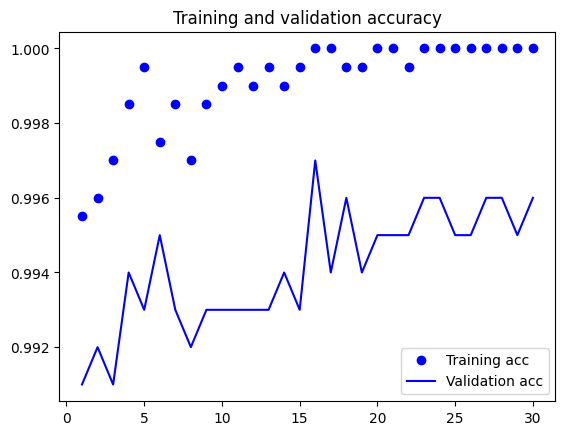

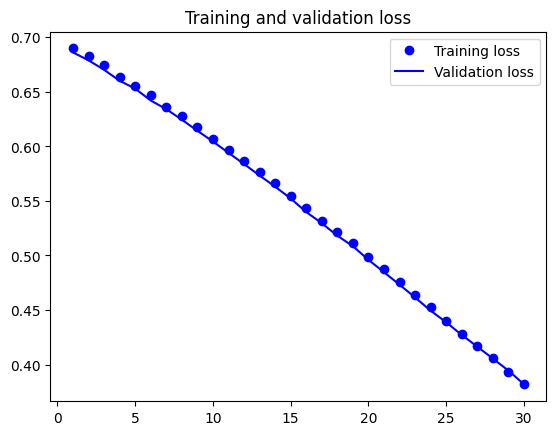

In [14]:
#plotting the results
import matplotlib.pyplot as plt 

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

Based on the given information, it's difficult to determine whether the model is overfitting or not. We can see that the training accuracy is very high, but the validation accuracy is also quite high, which suggests that the model is performing well on both the training and validation data. 

## Testing model on unseen data

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [18]:
#cat images dir
cats_dir = os.path.join(test_dir,"cats")
#dog images dir
dogs_dir = os.path.join(test_dir,"dogs")

**Checking prediction for a dog image. Correct prediction output would be dog**

In [92]:
file_names = os.listdir(dogs_dir)

img_path = os.path.join(dogs_dir, file_names[0])
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array_rescaled = img_array / 255.0
img_array_rescaled.shape

(150, 150, 3)

In [93]:
file_names[0]

'dog.1500.jpg'

In [94]:
img_array_prepd=np.expand_dims(img_array_rescaled, axis=0)
img_array_prepd.shape

(1, 150, 150, 3)

In [95]:
features = conv_base.predict(img_array_prepd)

1/1 [==============================] - 0s 107ms/step


In [96]:
features.shape

(1, 4, 4, 512)

In [97]:
features_reshaped = features.reshape(1, 4*4*512)
features_reshaped.shape

(1, 8192)

In [102]:
# Make predictions using your trained model
predictions = model.predict(features_reshaped)
print(predictions)
# print the predicted label
if predictions > 0.5:
    print('Dog Image')
else:
    print('Cat Image')

1/1 [==============================] - 0s 26ms/step
[[0.98007756]]
Dog Image


**For anyone who wants to replicate/use this code, I am not sure about the final results (and the training loss and accuracy curves), so just be aware of that**